In [1]:
!pip install -q albumentations==1.4.3 timm torchmetrics grad-cam==1.4.8 torchvision==0.18.0 opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 786.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, random, numpy as np, pandas as pd, cv2, matplotlib.pyplot as plt, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import timm, itertools
from tqdm import tqdm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [4]:
CSV_PATH = 'drive/MyDrive/dataset/labels.csv'  # <-- update if needed
IMG_DIR  = 'drive/MyDrive/dataset/images'      # <-- update if needed

df = pd.read_csv(CSV_PATH)
print(df['total_count'].value_counts())
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['total_count']])
print(f'Train: {len(train_df)}, Val: {len(val_df)}')

total_count
9     20
13    19
17    16
8     16
10    16
3     10
11     8
12     6
5      5
18     4
6      2
24     2
22     2
4      2
Name: count, dtype: int64
Train: 102, Val: 26


In [5]:
train_tfms = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8,1.0)),
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.05, scale=(0.95, 1.05), rotate=(-10, 10), p=0.5),
    A.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.5),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    A.CoarseDropout(max_holes=4, mask_fill_value=0, p=0.3),
    A.GaussianBlur(p=0.2),
    A.ImageCompression(60, 100, p=0.3),
    A.Normalize(),
    ToTensorV2(),
])

val_tfms = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(),
    ToTensorV2(),
])

In [6]:
class PalletDataset(Dataset):
    def __init__(self, df, img_dir, tfms):
        self.df = df.reset_index(drop=True)
        self.dir = img_dir; self.tfms=tfms
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(os.path.join(self.dir, row.filename))[:,:,::-1]
        img = self.tfms(image=img)['image']
        target = torch.tensor([row.total_count,row.chep_count,row.epal_count],dtype=torch.float)
        return img, target
train_dl = DataLoader(PalletDataset(train_df,IMG_DIR,train_tfms),batch_size=8,shuffle=True,num_workers=2)
val_dl   = DataLoader(PalletDataset(val_df,IMG_DIR,val_tfms),batch_size=8,shuffle=False,num_workers=2)

In [7]:
def get_metrics(preds, targs):
    metrics = {}
    for i, name in enumerate(['total', 'chep', 'epal']):
        y_true, y_pred = targs[:, i], preds[:, i]

        metrics[name] = dict(
            MAE  = mean_absolute_error(y_true, y_pred),
            RMSE = np.sqrt(mean_squared_error(y_true, y_pred)),
            R2   = r2_score(y_true, y_pred),
            MAPE = mean_absolute_percentage_error(y_true, y_pred)
        )
    return metrics



def train_one_model(model_name, epochs=15):
    model = timm.create_model(model_name, pretrained=True, num_classes=0)
    model = nn.Sequential(model, nn.Flatten(), nn.Linear(model.num_features,3))
    model.to(device)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                                   steps_per_epoch=len(train_dl), epochs=epochs)
    best_val = 1e9
    for ep in range(epochs):
        model.train(); tr_loss=0
        for x,y in train_dl:
            x,y=x.to(device),y.to(device)
            optimizer.zero_grad()
            out=model(x)
            loss=criterion(out,y)
            loss.backward(); optimizer.step(); scheduler.step()
            tr_loss+=loss.item()*x.size(0)
        model.eval(); preds,targets=[],[]
        with torch.no_grad():
            for x,y in val_dl:
                x=x.to(device)
                o=model(x).cpu(); preds.append(o); targets.append(y)
        preds=torch.cat(preds).numpy(); targets=torch.cat(targets).numpy()
        val_mae=get_metrics(preds,targets)['total']['MAE']
        print(f'{model_name} Epoch {ep+1}/{epochs} – TrainL {tr_loss/len(train_dl.dataset):.3f} – ValMAE {val_mae:.2f}')
        if val_mae<best_val:
            best_val=val_mae; torch.save(model.state_dict(), f'{model_name}_best.pth')
    return best_val

In [8]:
backbones = ['efficientnet_b3','resnet50','convnext_tiny']
results={}
for b in backbones:
    results[b]=train_one_model(b, epochs=15)
print('Best Val MAE per model:', results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


efficientnet_b3 Epoch 1/15 – TrainL 6.722 – ValMAE 10.52
efficientnet_b3 Epoch 2/15 – TrainL 6.250 – ValMAE 8.96
efficientnet_b3 Epoch 3/15 – TrainL 4.980 – ValMAE 3.32
efficientnet_b3 Epoch 4/15 – TrainL 2.684 – ValMAE 4.64
efficientnet_b3 Epoch 5/15 – TrainL 2.648 – ValMAE 2.70
efficientnet_b3 Epoch 6/15 – TrainL 2.246 – ValMAE 2.68
efficientnet_b3 Epoch 7/15 – TrainL 2.420 – ValMAE 1.99
efficientnet_b3 Epoch 8/15 – TrainL 2.017 – ValMAE 3.00
efficientnet_b3 Epoch 9/15 – TrainL 1.692 – ValMAE 1.91
efficientnet_b3 Epoch 10/15 – TrainL 1.344 – ValMAE 1.75
efficientnet_b3 Epoch 11/15 – TrainL 1.237 – ValMAE 1.40
efficientnet_b3 Epoch 12/15 – TrainL 1.019 – ValMAE 1.89
efficientnet_b3 Epoch 13/15 – TrainL 1.118 – ValMAE 1.54
efficientnet_b3 Epoch 14/15 – TrainL 0.920 – ValMAE 1.58
efficientnet_b3 Epoch 15/15 – TrainL 1.097 – ValMAE 1.59


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

resnet50 Epoch 1/15 – TrainL 6.758 – ValMAE 10.71
resnet50 Epoch 2/15 – TrainL 6.551 – ValMAE 9.95
resnet50 Epoch 3/15 – TrainL 5.997 – ValMAE 6.49
resnet50 Epoch 4/15 – TrainL 5.004 – ValMAE 4.48
resnet50 Epoch 5/15 – TrainL 3.686 – ValMAE 3.96
resnet50 Epoch 6/15 – TrainL 2.423 – ValMAE 1.99
resnet50 Epoch 7/15 – TrainL 2.099 – ValMAE 2.26
resnet50 Epoch 8/15 – TrainL 1.743 – ValMAE 3.01
resnet50 Epoch 9/15 – TrainL 1.894 – ValMAE 2.81
resnet50 Epoch 10/15 – TrainL 1.589 – ValMAE 2.29
resnet50 Epoch 11/15 – TrainL 1.534 – ValMAE 2.21
resnet50 Epoch 12/15 – TrainL 1.581 – ValMAE 2.23
resnet50 Epoch 13/15 – TrainL 1.356 – ValMAE 2.04
resnet50 Epoch 14/15 – TrainL 1.377 – ValMAE 1.92
resnet50 Epoch 15/15 – TrainL 1.284 – ValMAE 2.00


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

convnext_tiny Epoch 1/15 – TrainL 3.549 – ValMAE 3.02
convnext_tiny Epoch 2/15 – TrainL 2.307 – ValMAE 2.42
convnext_tiny Epoch 3/15 – TrainL 2.308 – ValMAE 4.51
convnext_tiny Epoch 4/15 – TrainL 2.188 – ValMAE 3.69
convnext_tiny Epoch 5/15 – TrainL 1.958 – ValMAE 2.47
convnext_tiny Epoch 6/15 – TrainL 1.906 – ValMAE 2.73
convnext_tiny Epoch 7/15 – TrainL 2.422 – ValMAE 3.87
convnext_tiny Epoch 8/15 – TrainL 2.042 – ValMAE 2.48
convnext_tiny Epoch 9/15 – TrainL 1.534 – ValMAE 2.51
convnext_tiny Epoch 10/15 – TrainL 1.252 – ValMAE 2.64
convnext_tiny Epoch 11/15 – TrainL 1.249 – ValMAE 2.17
convnext_tiny Epoch 12/15 – TrainL 1.070 – ValMAE 1.91
convnext_tiny Epoch 13/15 – TrainL 0.909 – ValMAE 1.75
convnext_tiny Epoch 14/15 – TrainL 0.841 – ValMAE 1.70
convnext_tiny Epoch 15/15 – TrainL 0.841 – ValMAE 1.70
Best Val MAE per model: {'efficientnet_b3': 1.4013011455535889, 'resnet50': 1.9177520275115967, 'convnext_tiny': 1.6956685781478882}


In [9]:
models=[]
for b in backbones:
    m = timm.create_model(b, pretrained=False, num_classes=0)
    m = nn.Sequential(m, nn.Flatten(), nn.Linear(m.num_features,3))
    m.load_state_dict(torch.load(f'{b}_best.pth', map_location=device))
    m.to(device).eval()
    models.append(m)

def ensemble_predict(x):
    with torch.no_grad():
        preds=[m(x) for m in models]
    return torch.stack(preds).mean(0)

# Evaluate ensemble
ensemble_preds, ensemble_targs = [],[]
with torch.no_grad():
    for x,y in val_dl:
        x=x.to(device)
        ensemble_preds.append(ensemble_predict(x).cpu())
        ensemble_targs.append(y)
ensemble_preds = torch.cat(ensemble_preds).numpy()
ensemble_targs = torch.cat(ensemble_targs).numpy()
print('Ensemble metrics:', get_metrics(ensemble_preds, ensemble_targs))

Ensemble metrics: {'total': {'MAE': 1.1506478786468506, 'RMSE': np.float64(1.6343321960562485), 'R2': 0.8745048642158508, 'MAPE': 0.11573401838541031}, 'chep': {'MAE': 0.9177365899085999, 'RMSE': np.float64(1.4573156166244563), 'R2': 0.9445345401763916, 'MAPE': 821948695183360.0}, 'epal': {'MAE': 0.8571485877037048, 'RMSE': np.float64(1.2950571947465466), 'R2': 0.9499572515487671, 'MAPE': 605835805851648.0}}



🔍 Grad-CAM for model 1 — efficientnet_b3


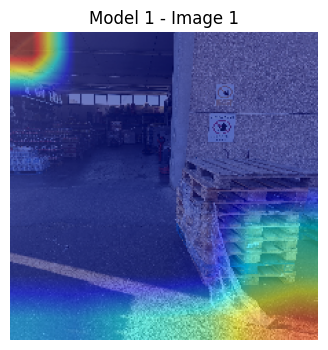

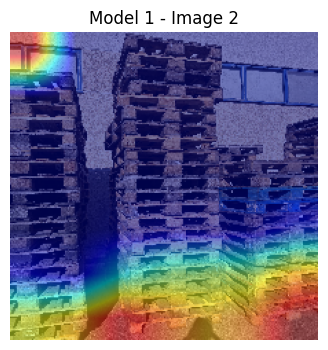

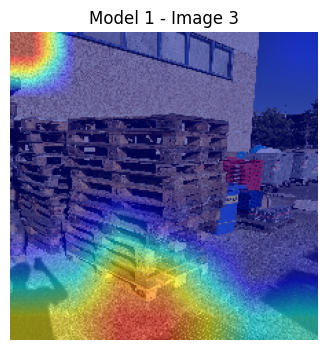

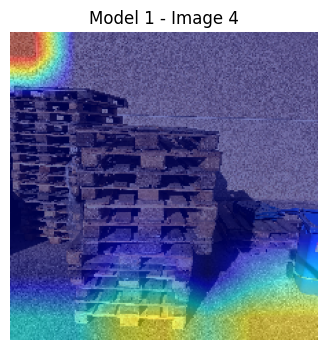

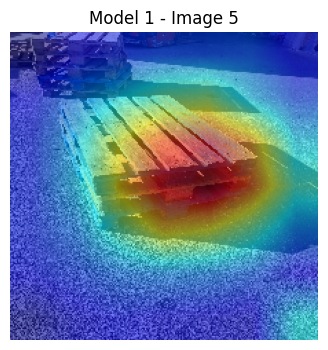

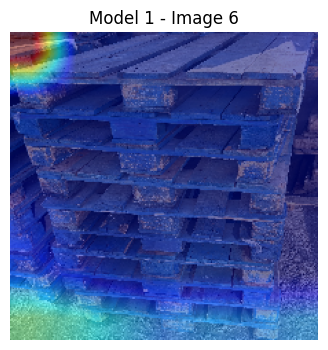

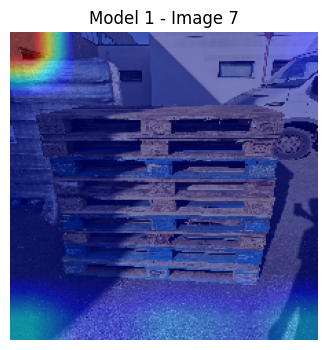

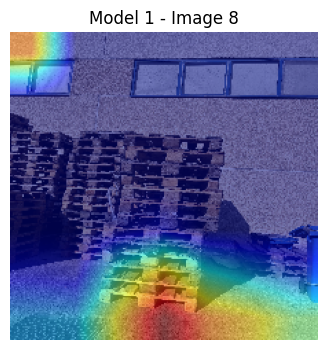

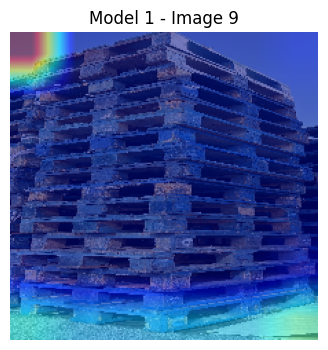

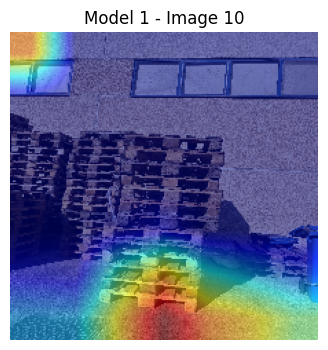


🔍 Grad-CAM for model 2 — resnet50


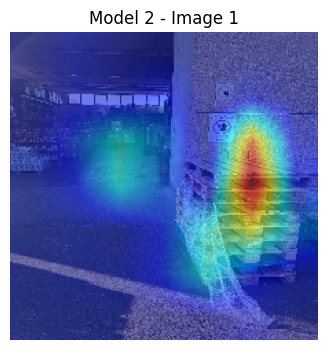

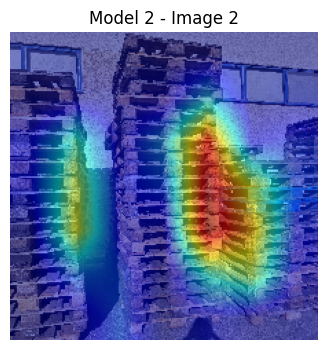

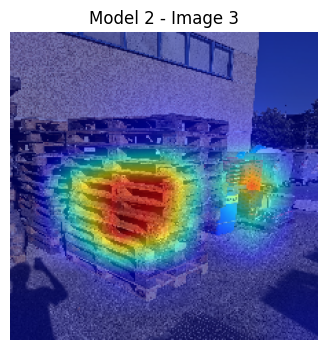

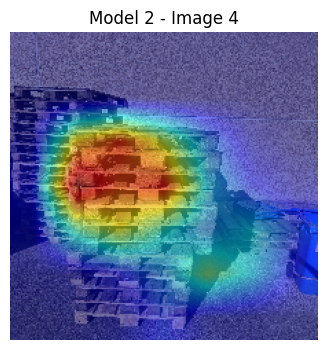

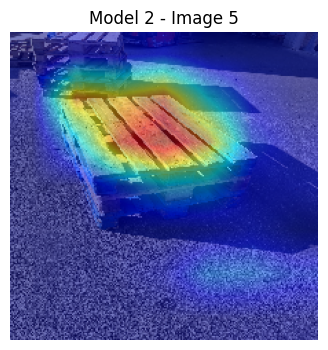

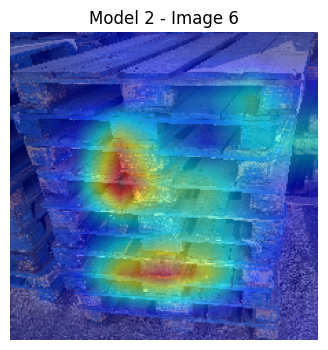

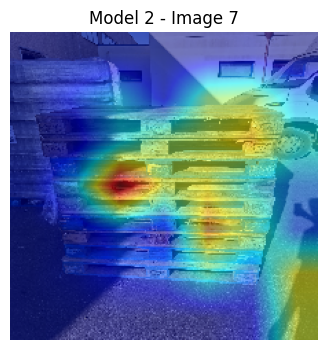

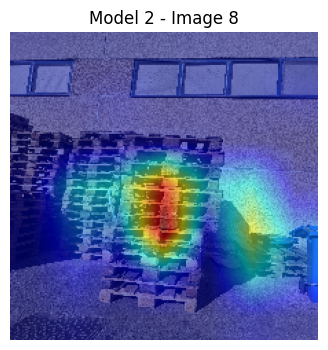

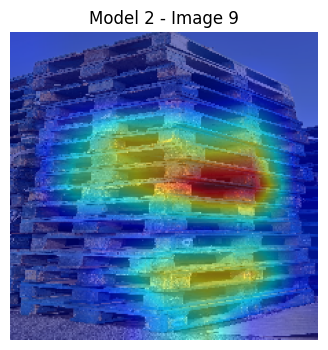

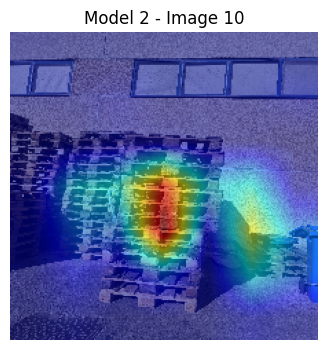


🔍 Grad-CAM for model 3 — convnext_tiny


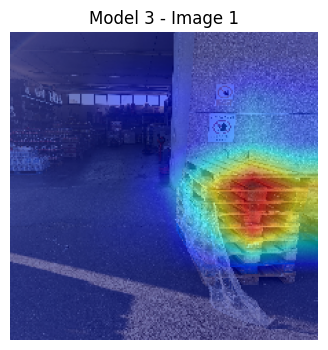

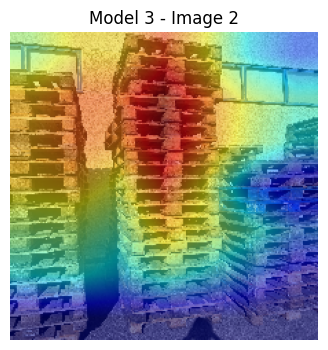

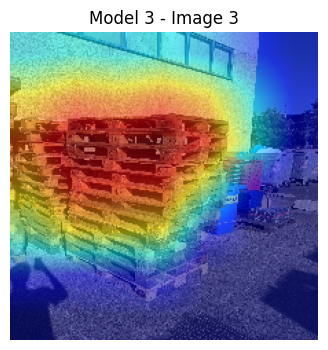

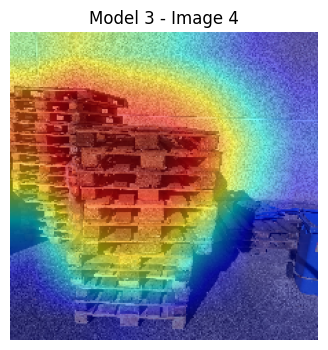

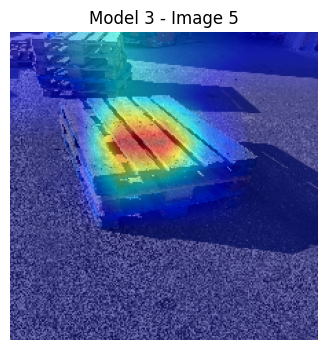

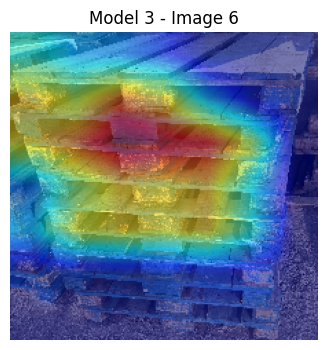

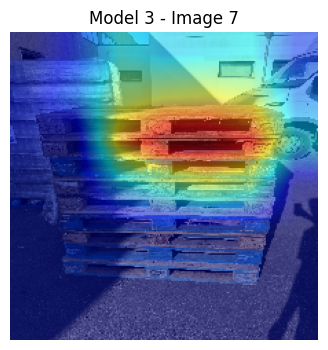

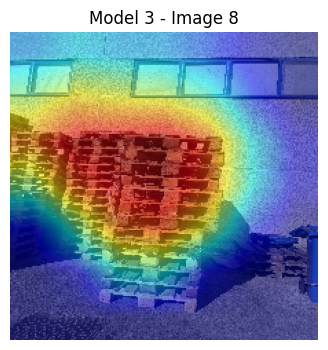

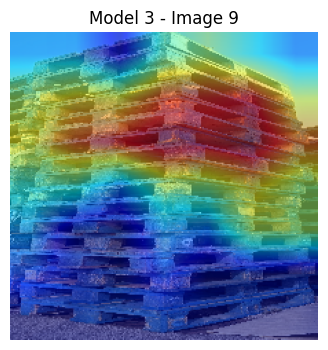

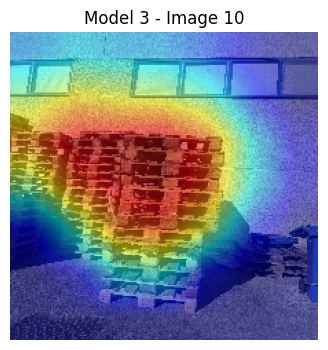

In [10]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def normalize_img(img_tensor):
    img = img_tensor.detach().cpu().permute(1, 2, 0).numpy()
    return (img - img.min()) / (img.max() - img.min() + 1e-6)

# --------- Optional: only show N samples per model ---------
max_images = 10

for model_idx, model in enumerate(models):
    backbone = backbones[model_idx]
    print(f"\n🔍 Grad-CAM for model {model_idx + 1} — {backbone}")

    # --------- Pick target layer based on model type ---------
    if "efficientnet" in backbone:
        target_layer = model[0].conv_head

    elif "resnet" in backbone:
        target_layer = model[0].layer4[-1]

    elif "convnext" in backbone:
      try:
          last_stage = model[0].stages[-1]
          last_block = list(last_stage.children())[-1]

          # Recursively search for first Conv2d inside the block
          def find_first_conv2d(module):
              for child in module.children():
                  if isinstance(child, nn.Conv2d):
                      return child
                  result = find_first_conv2d(child)
                  if result is not None:
                      return result
              return None

          target_layer = find_first_conv2d(last_block)
          if target_layer is None:
              raise ValueError("No Conv2d layer found in ConvNeXt block.")

      except Exception as e:
          print(f"❌ Failed to find ConvNeXt target layer: {e}")
          continue


    else:
        print(f"❌ Unsupported backbone: {backbone}")
        continue

    # --------- Create GradCAM object ---------
    cam = GradCAM(model=model,
                  target_layers=[target_layer],
                  use_cuda=(device == 'cuda'))

    shown = 0
    for batch_imgs, _ in val_dl:
        batch_imgs = batch_imgs.to(device)

        for i in range(batch_imgs.size(0)):
            img = batch_imgs[i]

            try:
                result = cam(img.unsqueeze(0))  # shape (1, H, W)
                if result is None or len(result) == 0:
                    print("⚠️ Empty CAM, skipping image.")
                    continue
                grayscale_cam = result[0]

                # Normalize original image and overlay CAM
                rgb = normalize_img(img)
                vis = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

                # Plot
                plt.figure(figsize=(4, 4))
                plt.imshow(vis)
                plt.title(f'Model {model_idx+1} - Image {shown+1}')
                plt.axis('off')
                plt.show()

                shown += 1
                if shown >= max_images:
                    break
            except Exception as e:
                print(f"⚠️ Error during CAM generation: {e}")
                continue

        if shown >= max_images:
            break


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images).cpu().numpy()
            targets = targets.numpy()
            all_preds.append(outputs)
            all_targets.append(targets)

    preds = np.vstack(all_preds)
    targets = np.vstack(all_targets)

    metrics = {}
    names = ['total_count', 'chep_count', 'epal_count']
    for i, name in enumerate(names):
        y_true = targets[:, i]
        y_pred = preds[:, i]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # manual RMSE
        r2 = r2_score(y_true, y_pred)
        metrics[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    return metrics, preds, targets


In [12]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_dict):
    metrics_names = ['MAE', 'RMSE', 'R2']
    task_names = list(metrics_dict.keys())

    for metric in metrics_names:
        values = [metrics_dict[task][metric] for task in task_names]
        plt.figure(figsize=(6, 4))
        plt.bar(task_names, values)
        plt.title(f'{metric} per Output')
        plt.ylabel(metric)
        plt.ylim(bottom=0)
        for i, v in enumerate(values):
            plt.text(i, v + 0.5, f"{v:.2f}", ha='center')
        plt.show()


In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# 1. safe MAPE function
# -------------------------
def filtered_mape(y_true, y_pred):
    """
    Mean Absolute Percentage Error (skipping targets == 0)
    Returns fraction, e.g. 0.148 for 14.8%
    """
    y_true = np.asarray(y_true).astype(np.float32)
    y_pred = np.asarray(y_pred).astype(np.float32)

    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.nan  # or return 0.0 if you'd rather not skip
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))



# -------------------------
# 2. general evaluation function
# -------------------------
def evaluate_callable(predict_fn, dataloader, device):
    """
    predict_fn: lambda x -> logits (B,3), already on correct device
    """
    all_preds, all_targets = [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            preds  = predict_fn(images).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets.numpy())

    preds   = np.vstack(all_preds)
    targets = np.vstack(all_targets)

    names   = ['total_count', 'chep_count', 'epal_count']
    metrics = {}
    for i, name in enumerate(names):
        y_true = targets[:, i].astype(np.float32)
        y_pred = preds[:, i].astype(np.float32)

        metrics[name] = {
            'MAE' : mean_absolute_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'R2'  : r2_score(y_true, y_pred),
            'MAPE': filtered_mape(y_true, y_pred),
        }
    return metrics

# -------------------------
# 3. evaluate each model backbone
# -------------------------
all_metrics = {}

for idx, (model, name) in enumerate(zip(models, backbones), 1):
    print(f"┏ Model {idx}: {name}")
    m_metrics = evaluate_callable(lambda x, m=model: m(x), val_dl, device)
    all_metrics[name] = m_metrics
    for k, v in m_metrics.items():
        print(f"  ┗ {k:12s}  MAE={v['MAE']:.3f}  RMSE={v['RMSE']:.3f}  R2={v['R2']:.3f}  MAPE={v['MAPE'] * 100:.1f}%")

# -------------------------
# 4. evaluate the ensemble
# -------------------------
ens_metrics = evaluate_callable(ensemble_predict, val_dl, device)
all_metrics["ensemble"] = ens_metrics

print("\n┏ Ensemble")
for k, v in ens_metrics.items():
    print(f"┗ {k:12s}  MAE={v['MAE']:.3f}  RMSE={v['RMSE']:.3f}  R2={v['R2']:.3f}  MAPE={v['MAPE'] * 100:.1f}%")


┏ Model 1: efficientnet_b3
  ┗ total_count   MAE=1.401  RMSE=1.845  R2=0.840  MAPE=16.3%
  ┗ chep_count    MAE=0.991  RMSE=1.537  R2=0.938  MAPE=21.5%
  ┗ epal_count    MAE=1.009  RMSE=1.407  R2=0.941  MAPE=17.2%
┏ Model 2: resnet50
  ┗ total_count   MAE=1.918  RMSE=2.400  R2=0.729  MAPE=18.1%
  ┗ chep_count    MAE=1.682  RMSE=2.454  R2=0.843  MAPE=39.6%
  ┗ epal_count    MAE=1.475  RMSE=2.043  R2=0.875  MAPE=24.7%
┏ Model 3: convnext_tiny
  ┗ total_count   MAE=1.696  RMSE=2.519  R2=0.702  MAPE=16.7%
  ┗ chep_count    MAE=0.721  RMSE=1.033  R2=0.972  MAPE=19.1%
  ┗ epal_count    MAE=1.426  RMSE=2.394  R2=0.829  MAPE=23.7%

┏ Ensemble
┗ total_count   MAE=1.151  RMSE=1.634  R2=0.875  MAPE=11.6%
┗ chep_count    MAE=0.918  RMSE=1.457  R2=0.945  MAPE=21.1%
┗ epal_count    MAE=0.857  RMSE=1.295  R2=0.950  MAPE=11.4%
